<a href="https://colab.research.google.com/github/dwahast/Deep-learning/blob/master/MLP_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objetivos deste trabalho
- Familiarizar-se com a biblioteca PyTorch
- Definir arquiteturas MLP simples em PyTorch
- Treinar utilizando CIFAR10, testando diferentes arquiteturas, parâmetros, funções de loss e otimizadores
- Comparar os resultados obtidos utilizando apenas Perpceptrons
- Link útil (https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c)

In [0]:
%matplotlib inline

import numpy as np 
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F # softmax

#import pandas as pd # organize files 


In [2]:
# Carregar os datasets

transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

dataset_train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

dataset_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_loader = DataLoader(dataset=dataset_train, shuffle=True)
test_loader = DataLoader(dataset=dataset_test, shuffle=False)
print(len(test_loader))

10000


In [0]:
# Definir a arquitetura MLP

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
        self.activation_function = nn.Sigmoid()
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = self.activation_function(self.fc1(x))
        x = self.activation_function(self.fc2(x))
        return x
# Arquitecture with RELU      
class MLP_relu(nn.Module):
    def __init__(self):
        super(MLP_relu, self).__init__()
        self.fc1 = nn.Linear(32*32, 20)
        self.fc2 = nn.Linear(20, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x),dim =1)
        return x
      
# New Arquitecture with RELU   
class MLP_Srelu(nn.Module):
    def __init__(self):
        super(MLP_Srelu, self).__init__()
        self.fc1 = nn.Linear(32*32, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 10)
    def forward(self, x):
        x = x.view(-1, 32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x),dim =1)
        return x   


In [0]:
model_std = MLP()
model_relu = MLP_relu()
model_Srelu = MLP_Srelu()
#print(model)

In [0]:
# Definir otimizador e loss
# Nota: testar outros otimizadores e funções de loss (em particular cross entropy)

def optimizer_set(model,optimizer_method, learning_rate):
  if optimizer_method == "sgd":
    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adadelta":
    optimizer = torch.optim.Adadelta(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adagrad":
    optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)
  elif optimizer_method == "adamax":
    optimizer = torch.optim.Adamax(model.parameters(), lr = learning_rate)
  elif optimizer_method == "rms":
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
  return optimizer

def loss_function_set(loss_function):
  if loss_function == "mse":
    loss_fn = torch.nn.MSELoss()
  elif loss_function == "nllos":
     loss_fn = torch.nn.NLLoss()
  elif loss_function == "cross":
     loss_fn = torch.nn.CrossEntropyLoss()
  return loss_fn
  

In [0]:
def one_hot(label, output_size):
    
    label_select = np.zeros(output_size)
    label_select[label]=1
    
    return torch.Tensor(label_select)

In [0]:
def evaluate(model, loss_function, dataset):
  model.eval() # set model to Evaluate "mode"
 # losses = []
  corrects = 0
  current_total = 0
  accuracies = 0
  
 # loss_fn = loss_function_set(loss_function)
  
  for image, label in dataset:
    outputs = model(image)
    
   # if(loss_function == 'mse'):
   #   label_target = one_hot(label,10) # one_hot to set the training class in the escalar
   #   loss = loss_fn(outputs,label_target)
   # else:
   #   loss = loss_fn(outputs,label)
      
   # losses.append(loss.item())
    
    _, predicted = torch.max(outputs.data, 1)
    
    if(predicted==label):
      corrects += 1
    
    current_total += 1
  
  accuracy = corrects/current_total

  return accuracy #, np.mean(losses)
      

#Training function

In [0]:
# Realizar o treinamento aqui
def fit(model, epochs, optimizer_method, loss_function, learning_rate):
  
  print("Opt Method:", optimizer_method.upper(), "| Loss Function:", loss_function.upper(), "| Learning Rate:", learning_rate)
  optimizer = optimizer_set(model,optimizer_method, learning_rate) #optimizer and Learning rate setter
  loss_fn = loss_function_set(loss_function) 
  accuracies = []
  losses = []
  train_acc = []
  for epoch in range(epochs):
    model.train() # Set model to TRAIN "mode" (can be set to False for Test)
    epoch_losses = []
    for image,label in train_loader:
      optimizer.zero_grad()  # cleaning gradients between mini batches
      outputs = model(image) 
     
      if(loss_function == 'mse'):
        label_target = one_hot(label,10) # one_hot to set the training class in the escalar
        loss = loss_fn(outputs,label_target)
      else: 
        loss = loss_fn(outputs, label)
        
      loss.backward() # Backpropagation 
      optimizer.step() # Optimization Method
      
      epoch_losses.append(loss.item())

    losses.append(np.mean(epoch_losses)) # Append mean losses for each epoch
   
    
    acc = evaluate(model, loss_function, train_loader)
    train_acc.append(acc)
    acc = evaluate(model, loss_function, test_loader) #evaluate
    accuracies.append(acc)
    
    #if(epoch%10==0):
    print("Epoch:",epoch, "- Average loss:", np.mean(epoch_losses),"- Accuracy:", acc) # Print mean Loss for each epoch
 
  return {
      "Model": outputs,
      "Acc": accuracies,
      "Train Acc": train_acc,
      "Loss": losses,
      "Name": optimizer_method + " | " + loss_function + " | " + str(learning_rate),
      "Arc": model
      #"Evaluate Train Loss": train_losses,
      
  }

# Training Your Model
- Variable "trained_models" append all models trained
- function "fit" train and return the Model and the all variable that will be used latter
  - *fit(Model, Epochs, Optimizer method, Loss function, Learning rate, momentum)*

In [10]:
# Avaliar o modelo aqui (no conjunto de teste)
trained_models = []
ep = 25 #epocas
trained_models.append(fit(model_Srelu,ep,"sgd", "cross", 0.01))


Opt Method: SGD | Loss Function: CROSS | Learning Rate: 0.01
Epoch: 0 - Average loss: 2.0712986106920614 - Accuracy: 0.2891
Epoch: 1 - Average loss: 1.9604914856082014 - Accuracy: 0.2991
Epoch: 2 - Average loss: 1.914032141123321 - Accuracy: 0.3264
Epoch: 3 - Average loss: 1.8839490118369786 - Accuracy: 0.3241
Epoch: 4 - Average loss: 1.8565922414367708 - Accuracy: 0.3066
Epoch: 5 - Average loss: 1.8343426412782815 - Accuracy: 0.3259
Epoch: 6 - Average loss: 1.8136476827707846 - Accuracy: 0.3508
Epoch: 7 - Average loss: 1.7955197176432942 - Accuracy: 0.326
Epoch: 8 - Average loss: 1.7833482163117311 - Accuracy: 0.3573
Epoch: 9 - Average loss: 1.7724362909541118 - Accuracy: 0.3616
Epoch: 10 - Average loss: 1.762945708078026 - Accuracy: 0.3514
Epoch: 11 - Average loss: 1.7490276745984115 - Accuracy: 0.3619
Epoch: 12 - Average loss: 1.745818556948064 - Accuracy: 0.341
Epoch: 13 - Average loss: 1.7376982464032884 - Accuracy: 0.36
Epoch: 14 - Average loss: 1.7288865757033014 - Accuracy: 0.3

In [11]:
trained_models.append(fit(model_relu,ep,"sgd", "cross", 0.01))

Opt Method: SGD | Loss Function: CROSS | Learning Rate: 0.01
Epoch: 0 - Average loss: 2.206798139694631 - Accuracy: 0.1796
Epoch: 1 - Average loss: 2.1406792406504227 - Accuracy: 0.2058
Epoch: 2 - Average loss: 2.108375342767928 - Accuracy: 0.2152
Epoch: 3 - Average loss: 2.090791848410666 - Accuracy: 0.2481
Epoch: 4 - Average loss: 2.0755400175541685 - Accuracy: 0.2517
Epoch: 5 - Average loss: 2.0510283879160673 - Accuracy: 0.2321
Epoch: 6 - Average loss: 2.0420472592153027 - Accuracy: 0.2537
Epoch: 7 - Average loss: 2.034787000824462 - Accuracy: 0.2402
Epoch: 8 - Average loss: 2.0260362716884583 - Accuracy: 0.2757
Epoch: 9 - Average loss: 2.0206933263132907 - Accuracy: 0.2634
Epoch: 10 - Average loss: 2.017755160059514 - Accuracy: 0.2854
Epoch: 11 - Average loss: 2.015393937327093 - Accuracy: 0.2721
Epoch: 12 - Average loss: 2.0120904047490984 - Accuracy: 0.2624
Epoch: 13 - Average loss: 2.010561599853345 - Accuracy: 0.24
Epoch: 14 - Average loss: 2.006150469422268 - Accuracy: 0.2819

In [12]:
trained_models.append(fit(model_std,ep,"sgd", "cross", 0.01))

Opt Method: SGD | Loss Function: CROSS | Learning Rate: 0.01
Epoch: 0 - Average loss: 2.2178344408535957 - Accuracy: 0.2446
Epoch: 1 - Average loss: 2.1486216933107376 - Accuracy: 0.2527
Epoch: 2 - Average loss: 2.1268301559615135 - Accuracy: 0.2722
Epoch: 3 - Average loss: 2.1126370102477074 - Accuracy: 0.2825
Epoch: 4 - Average loss: 2.101193777871132 - Accuracy: 0.2835
Epoch: 5 - Average loss: 2.0911605295038225 - Accuracy: 0.2993
Epoch: 6 - Average loss: 2.0825133217239378 - Accuracy: 0.3046
Epoch: 7 - Average loss: 2.0745993898653983 - Accuracy: 0.3093
Epoch: 8 - Average loss: 2.067130934972763 - Accuracy: 0.3126
Epoch: 9 - Average loss: 2.060771965632439 - Accuracy: 0.3186
Epoch: 10 - Average loss: 2.054257458472252 - Accuracy: 0.3237
Epoch: 11 - Average loss: 2.0492362650442124 - Accuracy: 0.3286
Epoch: 12 - Average loss: 2.045043985681534 - Accuracy: 0.3255
Epoch: 13 - Average loss: 2.040279405286312 - Accuracy: 0.3238
Epoch: 14 - Average loss: 2.037027691731453 - Accuracy: 0.3

In [44]:
#Another Optimizer
model_std = MLP()
model_relu = MLP_relu()
model_Srelu = MLP_Srelu()

trained_models1 = []

trained_models1.append(fit(model_Srelu,ep,"adadelta", "cross", 0.01))
trained_models1.append(fit(model_relu,ep,"adadelta", "cross", 0.01))
trained_models1.append(fit(model_std,ep,"adadelta", "cross", 0.01))

Opt Method: ADADELTA | Loss Function: CROSS | Learning Rate: 0.01
Epoch: 0 - Average loss: 2.1595754825755953 - Accuracy: 0.2274
Epoch: 1 - Average loss: 2.0811740418618916 - Accuracy: 0.2366
Epoch: 2 - Average loss: 2.0570735734796526 - Accuracy: 0.2583
Epoch: 3 - Average loss: 2.036419494776726 - Accuracy: 0.2332
Epoch: 4 - Average loss: 2.0134072666722536 - Accuracy: 0.3039
Epoch: 5 - Average loss: 2.0002261819742992 - Accuracy: 0.2326
Epoch: 6 - Average loss: 1.9942172896361352 - Accuracy: 0.2902
Epoch: 7 - Average loss: 1.9889197466730326 - Accuracy: 0.2854
Epoch: 8 - Average loss: 1.9861932916793599 - Accuracy: 0.3104
Epoch: 9 - Average loss: 1.9804945161269978 - Accuracy: 0.3155
Epoch: 10 - Average loss: 1.975350617162697 - Accuracy: 0.3091
Epoch: 11 - Average loss: 1.9715140229450445 - Accuracy: 0.2993
Epoch: 12 - Average loss: 1.974059485347448 - Accuracy: 0.3089
Epoch: 13 - Average loss: 1.9797873053704131 - Accuracy: 0.3122
Epoch: 14 - Average loss: 1.9786077587256095 - Accu

In [46]:
#Another Optimizer
model_std = MLP()
model_relu = MLP_relu()
model_Srelu = MLP_Srelu()

trained_models2 = []

trained_models2.append(fit(model_Srelu,ep,"sgd", "mse", 0.01))
trained_models2.append(fit(model_relu,ep,"sgd", "mse", 0.01))
trained_models2.append(fit(model_std,ep,"sgd", "mse", 0.01))

Opt Method: SGD | Loss Function: MSE | Learning Rate: 0.01
Epoch: 0 - Average loss: 5.860953749799728 - Accuracy: 0.2961
Epoch: 1 - Average loss: 5.860021422691346 - Accuracy: 0.3323
Epoch: 2 - Average loss: 5.8595053579330445 - Accuracy: 0.3364
Epoch: 3 - Average loss: 5.859140379886627 - Accuracy: 0.3624
Epoch: 4 - Average loss: 5.8588371799755095 - Accuracy: 0.3641
Epoch: 5 - Average loss: 5.858576901874542 - Accuracy: 0.3712
Epoch: 6 - Average loss: 5.858356099843979 - Accuracy: 0.3864
Epoch: 7 - Average loss: 5.858139945106506 - Accuracy: 0.386
Epoch: 8 - Average loss: 5.8579520998573305 - Accuracy: 0.4012
Epoch: 9 - Average loss: 5.857758838462829 - Accuracy: 0.3901
Epoch: 10 - Average loss: 5.85757956366539 - Accuracy: 0.4029
Epoch: 11 - Average loss: 5.857409520788193 - Accuracy: 0.4126
Epoch: 12 - Average loss: 5.857250818662643 - Accuracy: 0.4123
Epoch: 13 - Average loss: 5.857097074365615 - Accuracy: 0.4034
Epoch: 14 - Average loss: 5.856930483989715 - Accuracy: 0.4118
Epoch

# Text and Graphical Output

In [0]:
def graphical_outputs(trained_models):
  plt.title("\n\nAccuracy " + trained_models[0]["Name"].upper() +"\n", fontsize=20, loc="left")
  plt.title("dotted line = train")
  for models in trained_models:
    plt.plot(models["Acc"], label = str(models["Arc"]).partition("(")[0])
    plt.plot(models["Train Acc"],"--") 
    print(models["Arc"],"\n", "ACC: ", np.mean(models["Acc"]),"\n")

  plt.legend(loc='best')
  plt.show


MLP_Srelu(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
) 
 ACC:  0.347404 

MLP_relu(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
) 
 ACC:  0.253724 

MLP(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (activation_function): Sigmoid()
) 
 ACC:  0.31474 



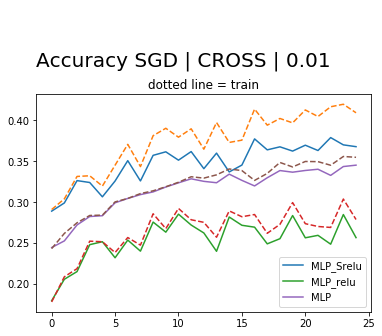

In [43]:
graphical_outputs(trained_models)

MLP_Srelu(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
) 
 ACC:  0.292792 

MLP_relu(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
) 
 ACC:  0.29122800000000004 

MLP(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (activation_function): Sigmoid()
) 
 ACC:  0.20382800000000004 



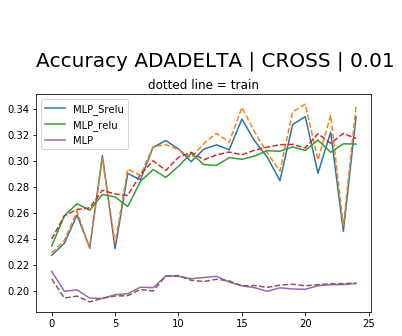

In [45]:
graphical_outputs(trained_models1)

MLP_Srelu(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=10, bias=True)
) 
 ACC:  0.397756 

MLP_relu(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
) 
 ACC:  0.26865600000000006 

MLP(
  (fc1): Linear(in_features=1024, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (activation_function): Sigmoid()
) 
 ACC:  0.239296 



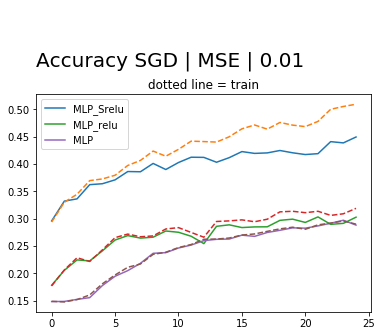

In [47]:
graphical_outputs(trained_models2)